# Imports

In [58]:
%reload_ext autoreload
%autoreload 2

In [59]:
import sys
sys.path.append('/workspace/deep_birth_death/src/')

In [60]:
import pickle
import itertools
import time
import os
import statistics
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model

from evaluation.regression import get_regression_metrics, plot_errors, plot_errors_boxplot, predicted_minus_target_vs_target

In [61]:
pd.options.display.float_format = "{:,.4f}".format

# Results generation

In [62]:
pickle_base = '/workspace/deep_birth_death/deep_learning/pickles/testing_k/dataset_'
res_path = "/workspace/deep_birth_death/deep_learning//models/testing_k_reg/"
n_tips = ['674', '489', '87']

data = dict()
for i in n_tips:
    with open(pickle_base + i + "_10k.pkl", 'rb') as f:
        data[i] = pickle.load(f)

In [63]:
n_trees_tested = 1000
results = dict()
inf_times = dict()

for i in n_tips:
    print('---', i, 'tips ---')
    results[i] = dict()
    inf_times[i] = dict()
    
    for label in np.unique(data[i]['div_info_test']):
        div_scenario = label.split('/')[1].split('_')[0]
        results[i][div_scenario] = dict()
        inf_times[i][div_scenario] = dict()
        
        #Load the model
        model_path = res_path + div_scenario + '/' + i + "_regression_"
        nn_model = load_model(model_path + 'model.keras')
        
        #Predict
        start_time = time()
        pred = nn_model.predict(np.expand_dims(data[i]['X_test'][data[i]['div_info_test'] == label], axis=2))
        ex_time = time() - start_time
        print("--- Inference time: ", div_scenario, "scenario &", ex_time, "seconds ---")  
        
        #Load the real parameter values and the rescale factor for rescaling the predictions  
        y_reg_test = data[i]['y_reg_test'][data[i]['div_info_test'] == label]
        y_reg_test = [np.array(elem) for elem in y_reg_test]
        real = y_reg_test
        
        resc_factor_test = data[i]['resc_factor_test'][data[i]['div_info_test'] == label]
            
        #Rescale the corresponding parameter values     
        if div_scenario == "BD" or div_scenario == "HE" or div_scenario == "SAT":
            
            pred[:, 0] = pred[:, 0] / resc_factor_test
        elif div_scenario == "ME":
            
            pred[:, 0] = pred[:, 0] / resc_factor_test
            pred[:, 2] = pred[:, 2] / resc_factor_test
        else:

            pred[:, 0] = pred[:, 0] / resc_factor_test
            pred[:, 1] = pred[:, 1] / resc_factor_test
            pred[:, 4] = pred[:, 4] / resc_factor_test
            
        #Estimate the errors 
            
        abs_error = abs(pred-real)
        raw_error = pred-real
        r_error = abs((pred - real)/ real)
        
        #Save the results
        results[i][div_scenario]['raw_error'] = raw_error
        results[i][div_scenario]['abs_error'] = abs_error
        results[i][div_scenario]['real_values'] = real
        
        results[i][div_scenario]['MAE'] = np.mean(abs_error, axis=0)
        results[i][div_scenario]['MRE'] = np.mean(r_error, axis=0)
        
        inf_times[i][div_scenario] = ex_time

--- 674 tips ---
--- Inference time:  BD scenario & 0.2139301300048828 seconds ---
--- Inference time:  HE scenario & 0.1395111083984375 seconds ---
--- Inference time:  ME scenario & 0.15029287338256836 seconds ---
--- Inference time:  SAT scenario & 0.13860344886779785 seconds ---
--- Inference time:  SR scenario & 0.1761643886566162 seconds ---
--- Inference time:  WW scenario & 0.1529989242553711 seconds ---
--- 489 tips ---
--- Inference time:  BD scenario & 0.09693408012390137 seconds ---
--- Inference time:  HE scenario & 0.10283160209655762 seconds ---
--- Inference time:  ME scenario & 0.12882089614868164 seconds ---
--- Inference time:  SAT scenario & 0.09072637557983398 seconds ---
--- Inference time:  SR scenario & 0.13199639320373535 seconds ---
--- Inference time:  WW scenario & 0.13089227676391602 seconds ---
--- 87 tips ---
--- Inference time:  BD scenario & 0.09566950798034668 seconds ---
--- Inference time:  HE scenario & 0.08893847465515137 seconds ---
--- Inference 

# Inference time

In [64]:
for i in inf_times:
    t = []
    for scenario in inf_times[i]:
        t.append(inf_times[i][scenario])
   
    print(f"\nInference time statistics for {i}:")
    print(f"Mean: {np.mean(t):.4f}")
    print(f"Standard deviation: {np.std(t):.4f}")
    print(f"Minimum: {np.min(t):.4f}")
    print(f"Maximum: {np.max(t):.4f}")


Inference time statistics for 674:
Mean: 0.1619
Standard deviation: 0.0264
Minimum: 0.1386
Maximum: 0.2139

Inference time statistics for 489:
Mean: 0.1137
Standard deviation: 0.0173
Minimum: 0.0907
Maximum: 0.1320

Inference time statistics for 87:
Mean: 0.0961
Standard deviation: 0.0096
Minimum: 0.0806
Maximum: 0.1093


## Training time

In [65]:
for i in n_tips:
    train_times = []
    
    for label in np.unique(data[i]['div_info_test']):
        div_scenario = label.split('/')[1].split('_')[0]
        
        # Load regression model 
        model_path = res_path + div_scenario + '/' + i + "_regression_"

        with open(model_path + 'model_data.pkl', 'rb') as f:
            n_params, train_time = pickle.load(f)
                
        train_times.append(train_time)
    
    print('\nTraining times for', i, 'tips')
    print('-'*5)
    print('Mean:', np.mean(train_times))
    print('Std Dev:', np.std(train_times))
    print('Max:', np.max(train_times))
    print('Min:', np.min(train_times))


Training times for 674 tips
-----
Mean: 137.90498642126718
Std Dev: 25.46996438708959
Max: 166.80518674850464
Min: 103.87500929832458

Training times for 489 tips
-----
Mean: 240.14500681559244
Std Dev: 78.79281024507148
Max: 371.26671171188354
Min: 148.30097079277039

Training times for 87 tips
-----
Mean: 229.15582263469696
Std Dev: 84.28985180091844
Max: 362.7372832298279
Min: 136.438973903656


## Get regression metrics

In [66]:
n_tips = ['674', '489', '87']
div_scenarios = ['BD', 'HE', 'ME', 'SAT', 'SR', 'WW']

### MAE

In [67]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios: 
        print(scenario)
        data = get_regression_metrics(results, tip, scenario, 'MAE')
        print(data)

---------674---------
BD
         r      a
MAE 0.1278 0.0733
HE
         r      a
MAE 0.2043 0.0177
ME
         r      a   time   frac
MAE 0.0338 0.0649 5.3041 0.0483
SAT
     lambda 0
MAE    0.0862
SR
        r0     r1     a0     a1   time
MAE 0.0683 0.0209 0.1101 0.0935 3.4404
WW
        r0     r1     a0     a1   time
MAE 0.0353 0.1011 0.1427 0.0888 2.6966
---------489---------
BD
         r      a
MAE 0.1335 0.0738
HE
         r      a
MAE 0.2179 0.0184
ME
         r      a   time   frac
MAE 0.0343 0.0727 5.4944 0.0484
SAT
     lambda 0
MAE    0.0985
SR
        r0     r1     a0     a1   time
MAE 0.0617 0.0217 0.1017 0.0908 3.4429
WW
        r0     r1     a0     a1   time
MAE 0.0309 0.1036 0.1423 0.0883 2.5518
---------87---------
BD
         r      a
MAE 0.2596 0.1094
HE
         r      a
MAE 0.3453 0.0239
ME
         r      a   time   frac
MAE 0.0375 0.0956 5.5167 0.0497
SAT
     lambda 0
MAE    0.2142
SR
        r0     r1     a0     a1   time
MAE 0.0753 0.0204 0.1069 0.0937 2.9239

### MRE

In [68]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios: 
        print(scenario)
        data = get_regression_metrics(results, tip, scenario, 'MRE')
        print(data)

---------674---------
BD
         r      a
MRE 0.0651 0.7432
HE
         r      a
MRE 0.1043 0.0209
ME
         r      a   time   frac
MRE 0.1110 0.1366 0.7980 0.2759
SAT
     lambda 0
MRE    0.0448
SR
        r0     r1     a0     a1   time
MRE 0.1119 0.5146 0.6959 0.1287 0.5498
WW
        r0     r1     a0     a1   time
MRE 0.5507 0.1164 0.0871 0.2293 0.2490
---------489---------
BD
         r      a
MRE 0.0668 0.6784
HE
         r      a
MRE 0.1124 0.0217
ME
         r      a   time   frac
MRE 0.1173 0.1577 0.8348 0.2755
SAT
     lambda 0
MRE    0.0497
SR
        r0     r1     a0     a1   time
MRE 0.1095 0.6142 0.6765 0.1256 0.6038
WW
        r0     r1     a0     a1   time
MRE 0.4248 0.1173 0.0878 0.2191 0.2337
---------87---------
BD
         r      a
MRE 0.1230 1.1552
HE
         r      a
MRE 0.1745 0.0282
ME
         r      a   time   frac
MRE 0.1661 0.1968 0.8284 0.2905
SAT
     lambda 0
MRE    0.1072
SR
        r0     r1     a0     a1   time
MRE 0.1484 0.6033 0.6478 0.1267 0.5604

### Errors boxplots 

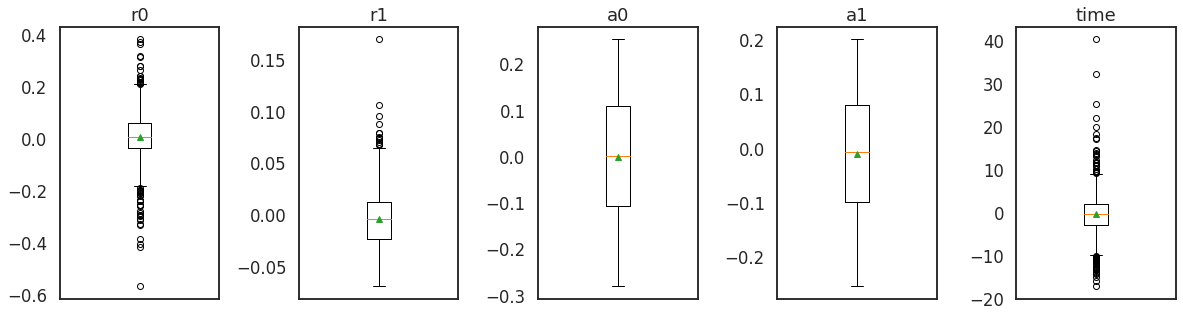

In [82]:
plot_errors_boxplot(results, "674", "SR")

---------674---------


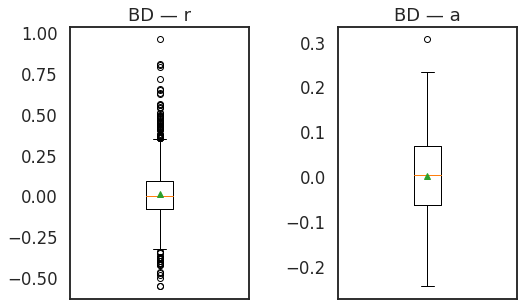

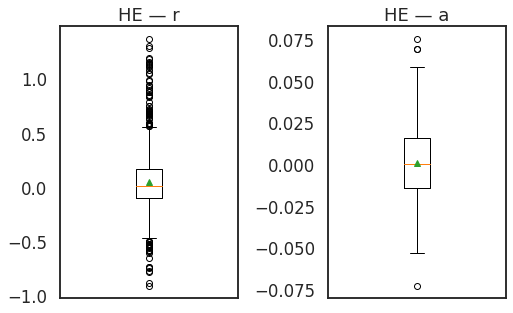

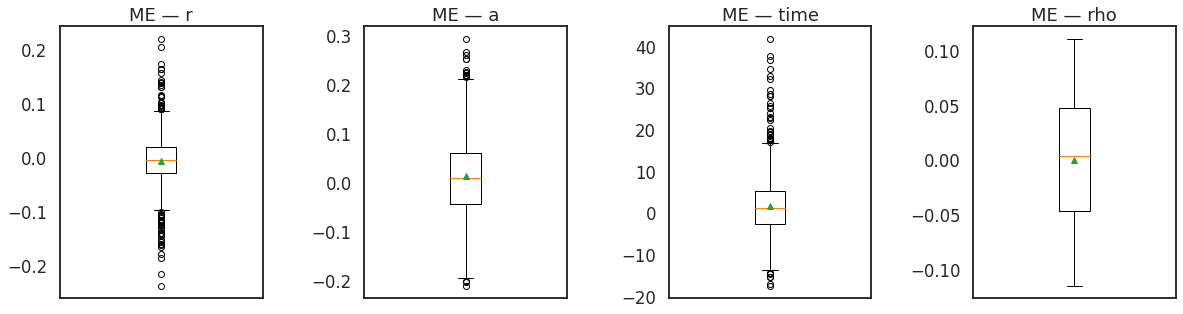

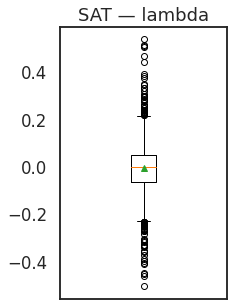

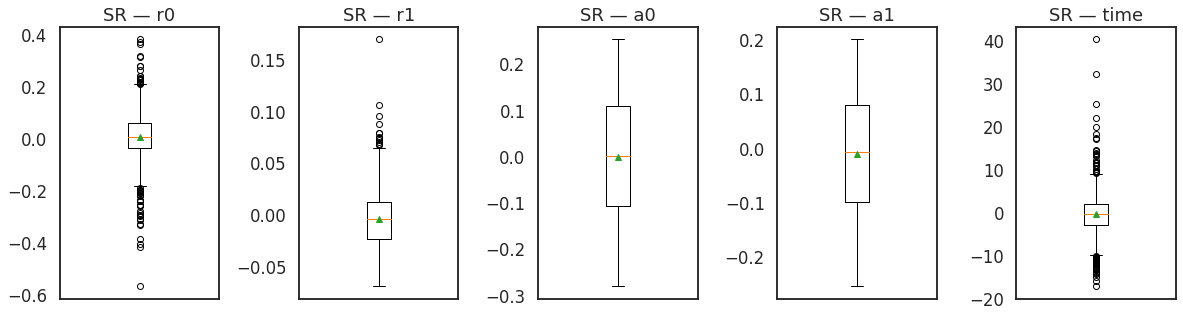

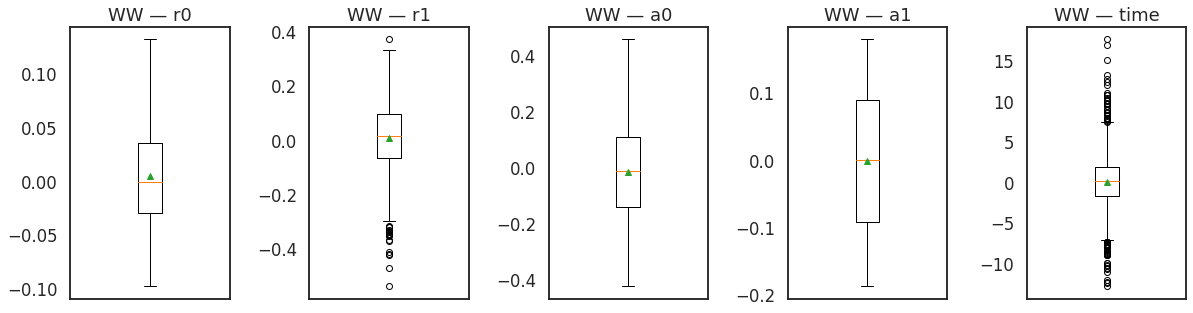

---------489---------


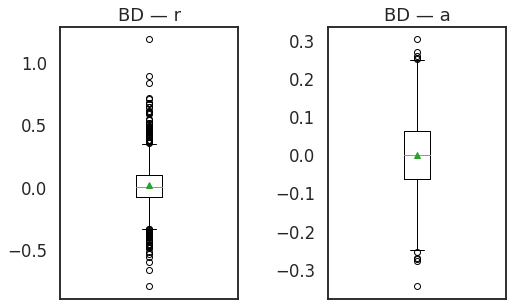

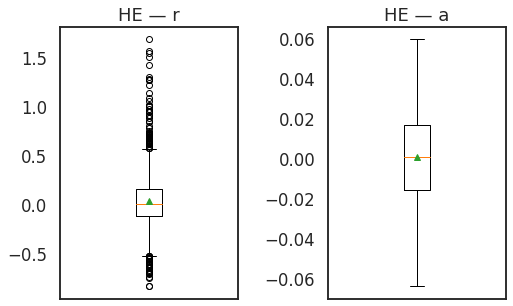

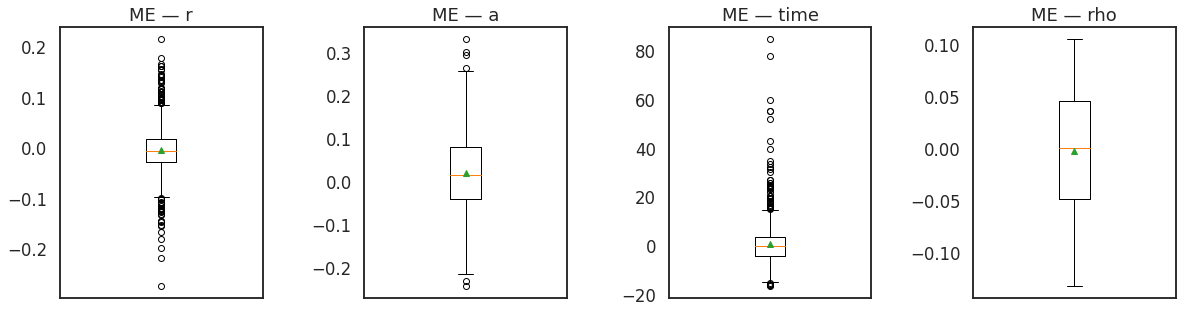

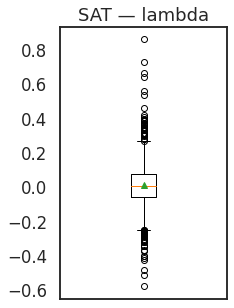

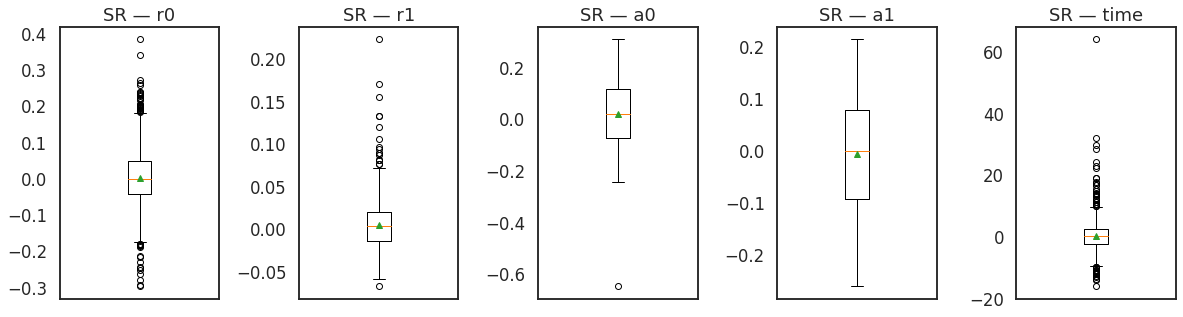

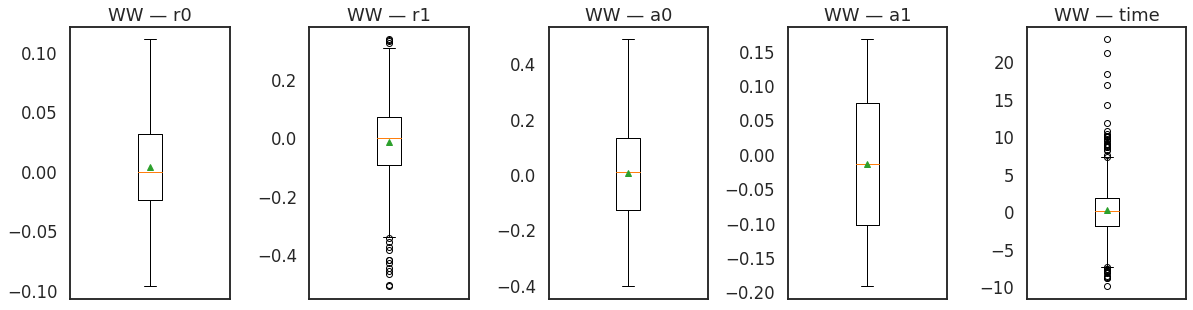

---------87---------


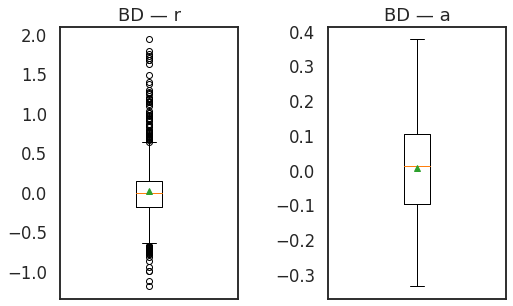

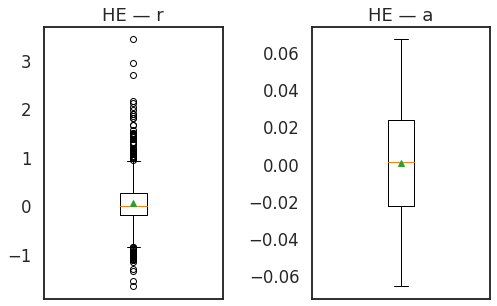

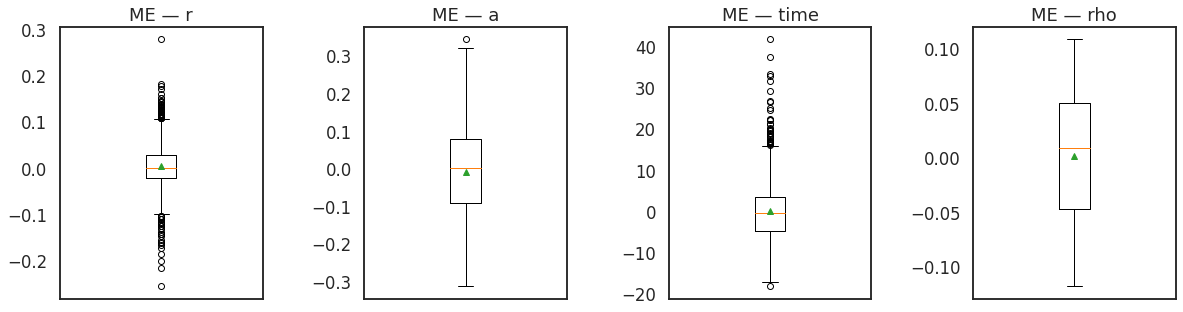

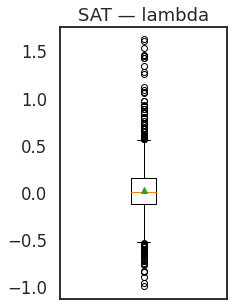

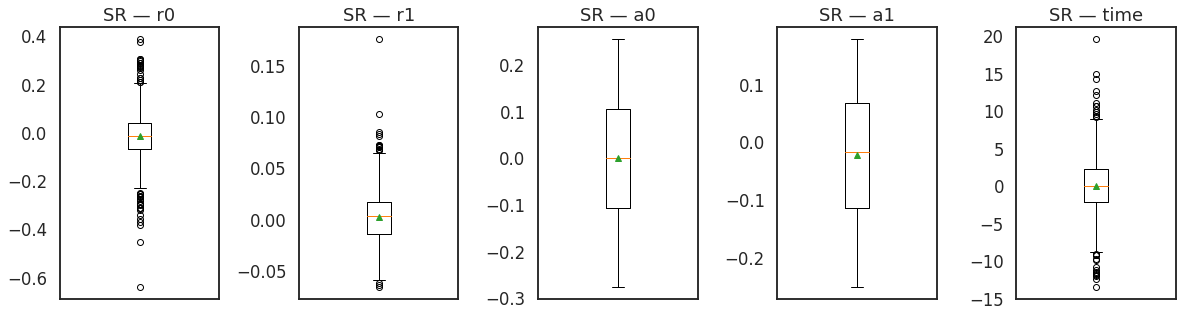

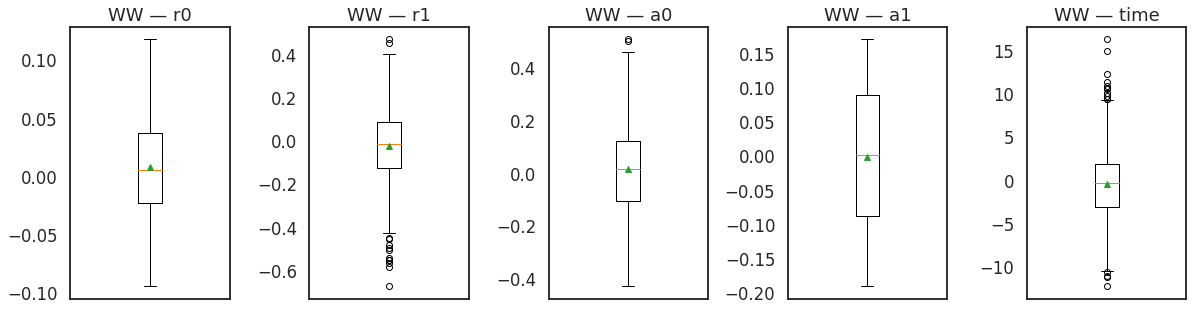

In [90]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios:
        #print(scenario)
        plot_errors_boxplot(results, tip, scenario)

### Errors swarmplots 

---------674---------
BD


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


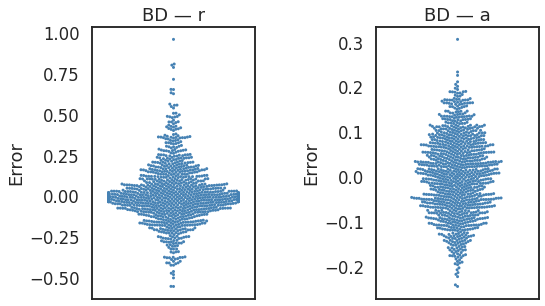

HE


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


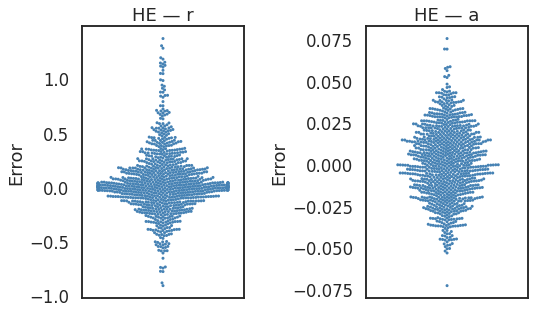

ME


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


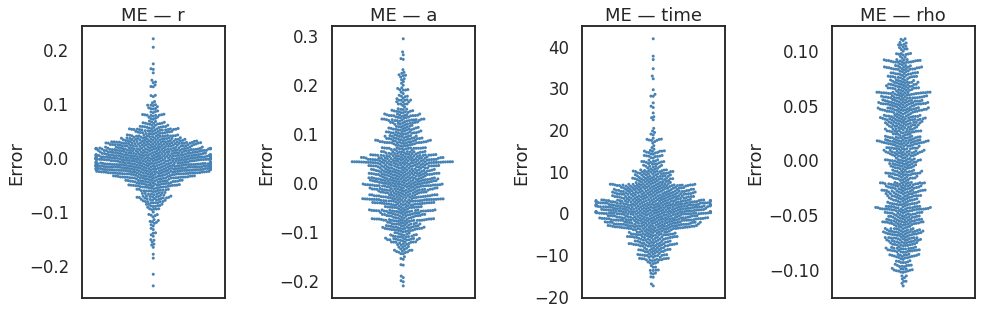

SAT


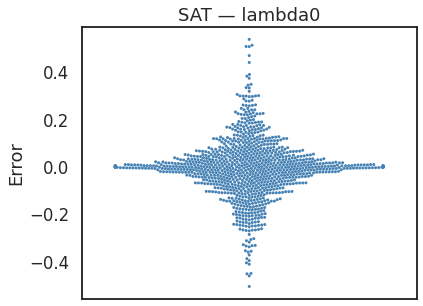

SR


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


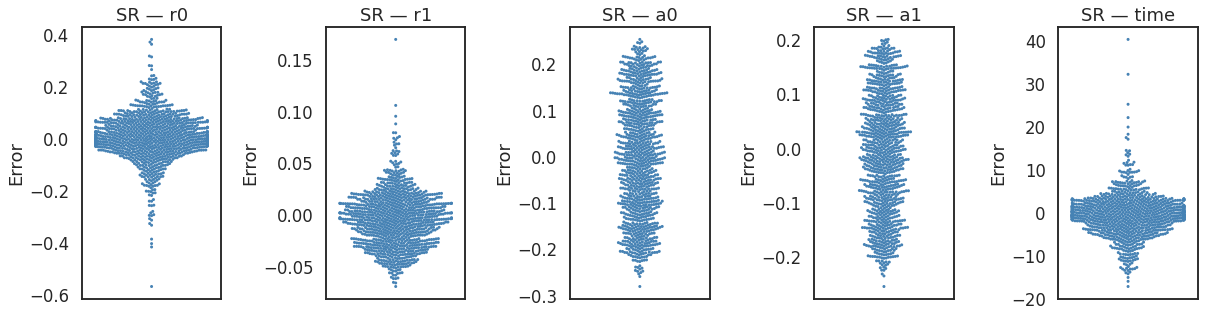

WW


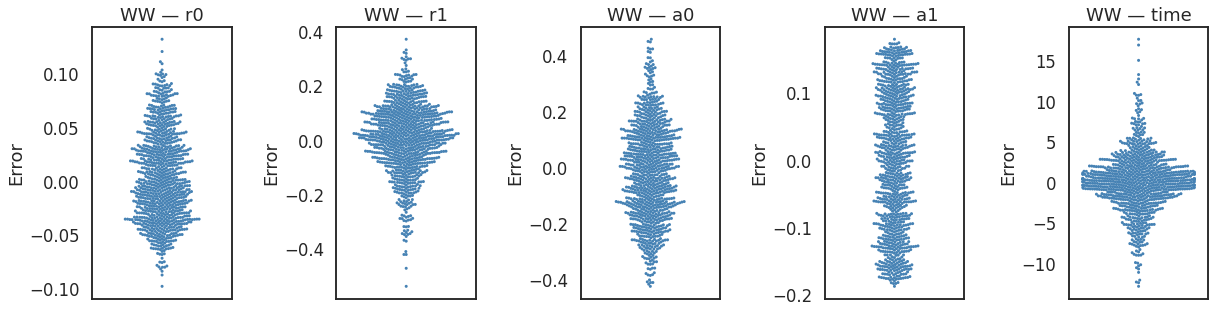

---------489---------
BD


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


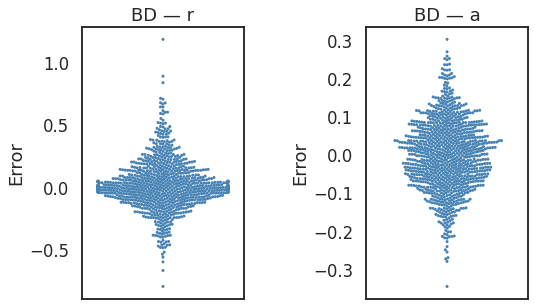

HE


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


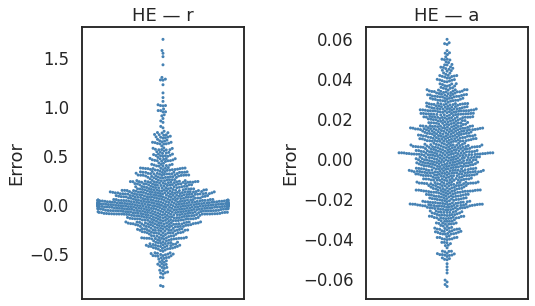

ME


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


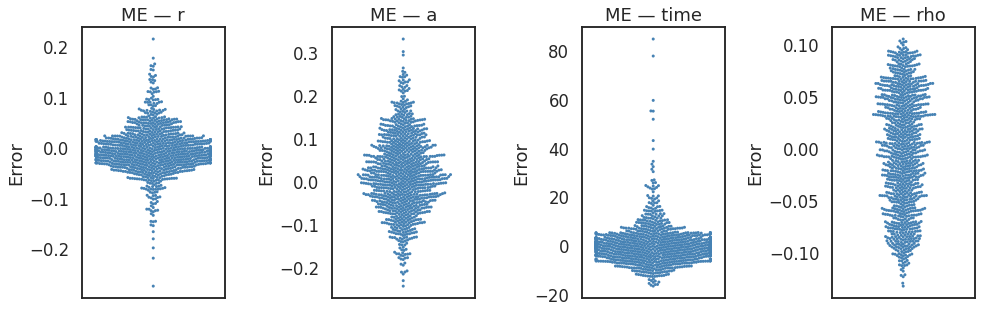

SAT


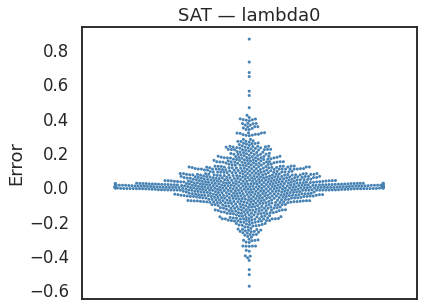

SR


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 27.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


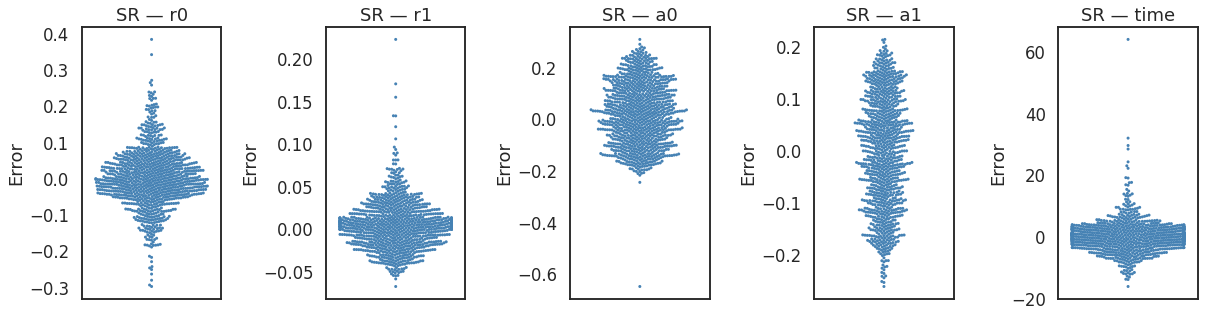

WW


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


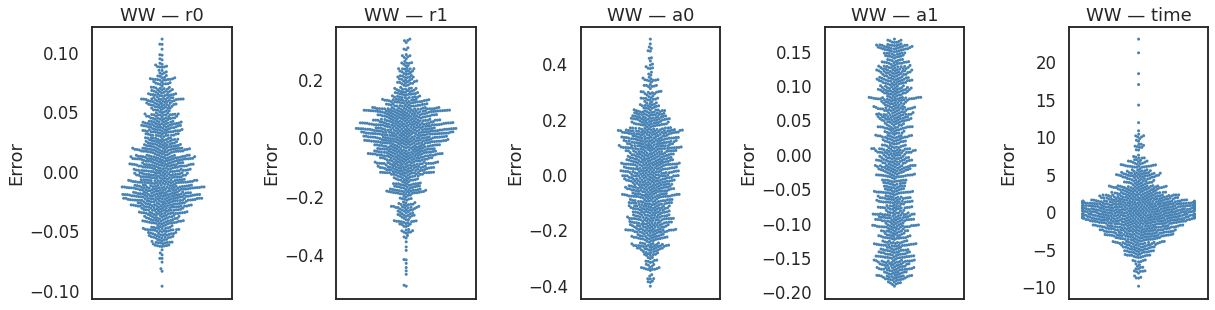

---------87---------
BD


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


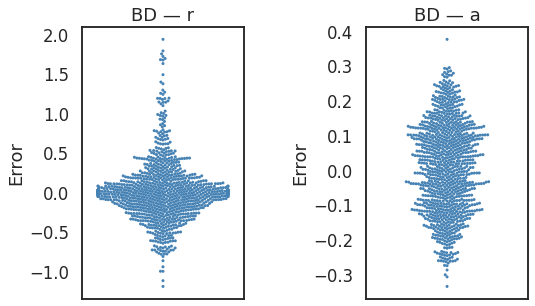

HE


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


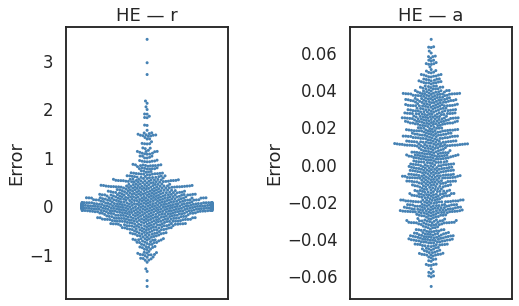

ME


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


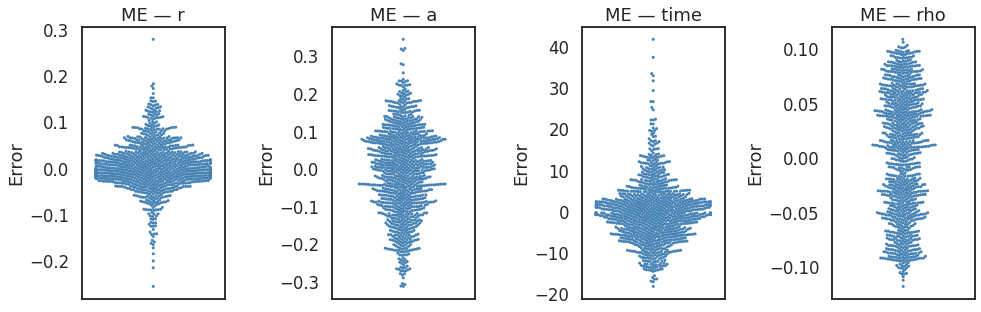

SAT


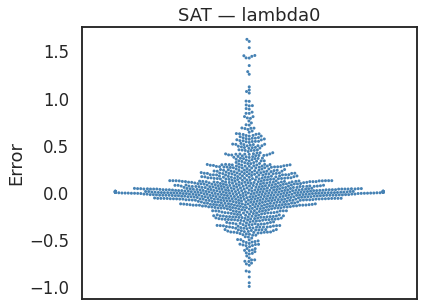

SR


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


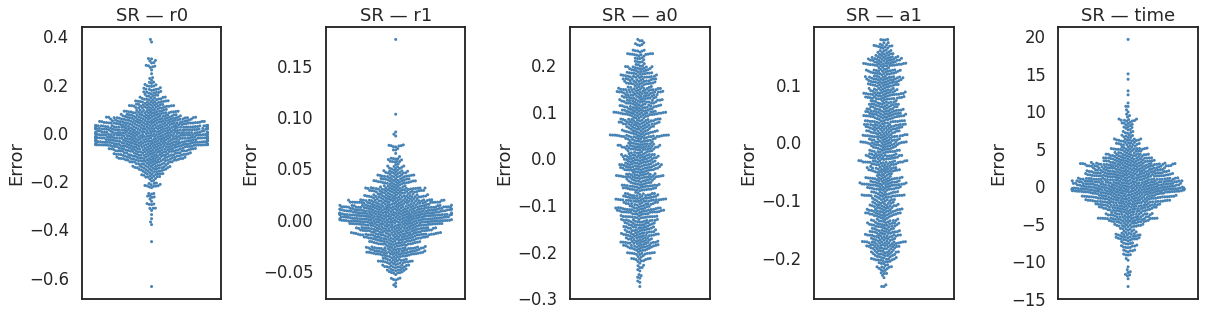

WW


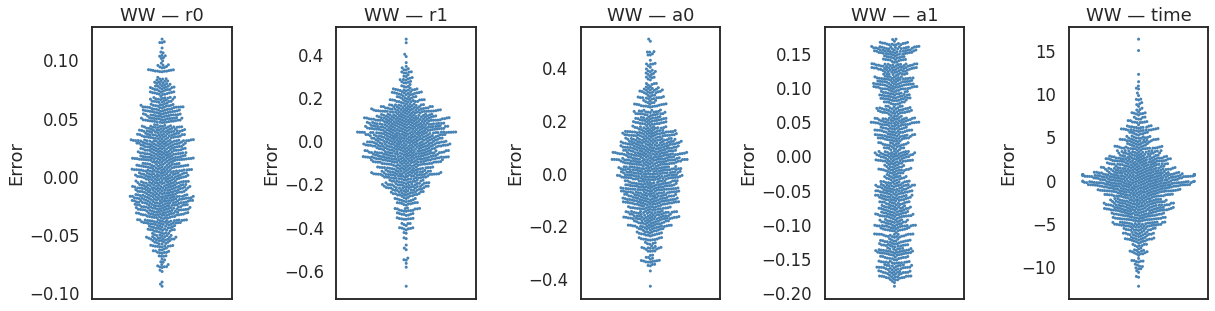

In [91]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios:
        print(scenario)
        plot_errors(results, tip, scenario)

### Absolute errors vs target

---------674---------


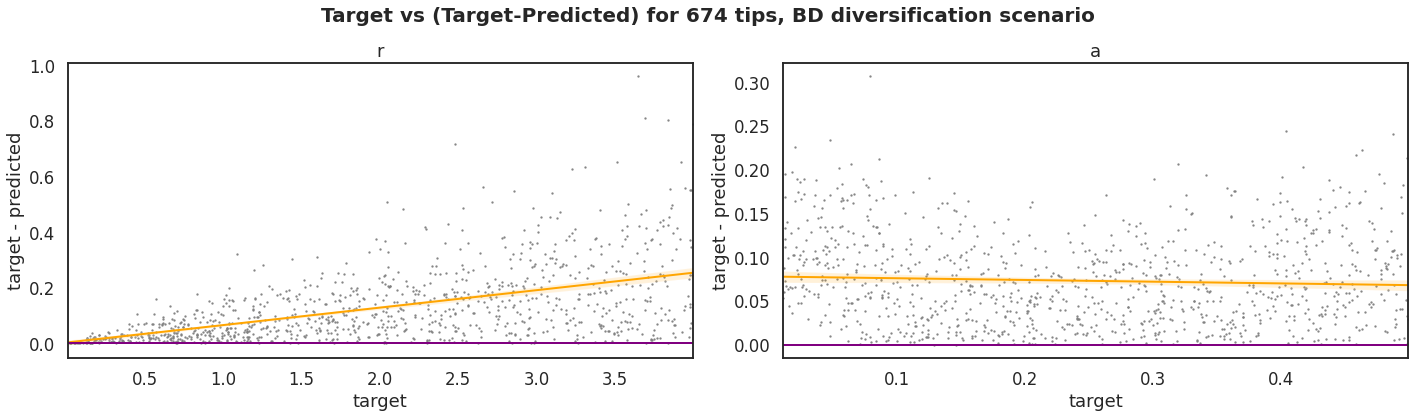

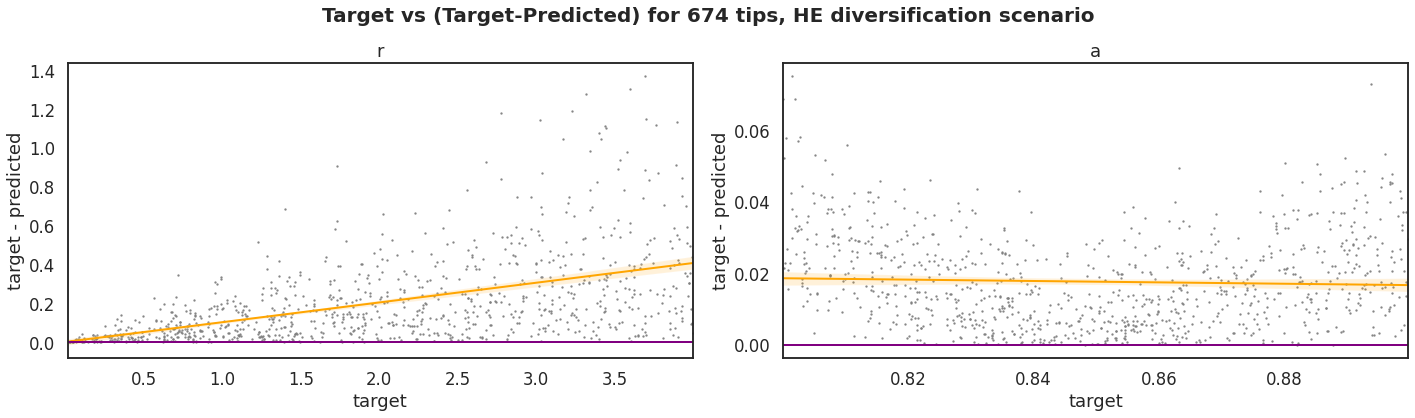

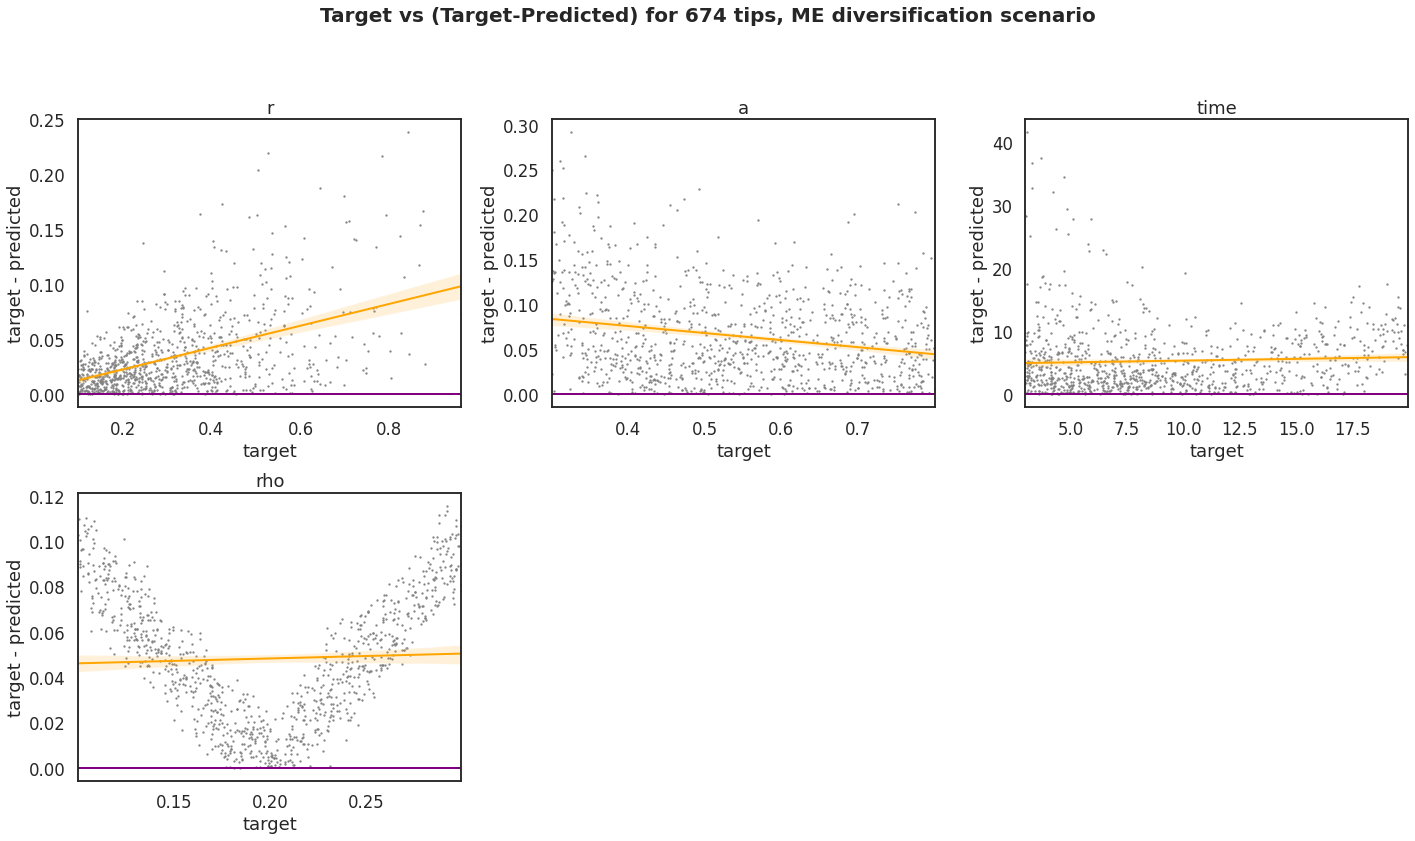

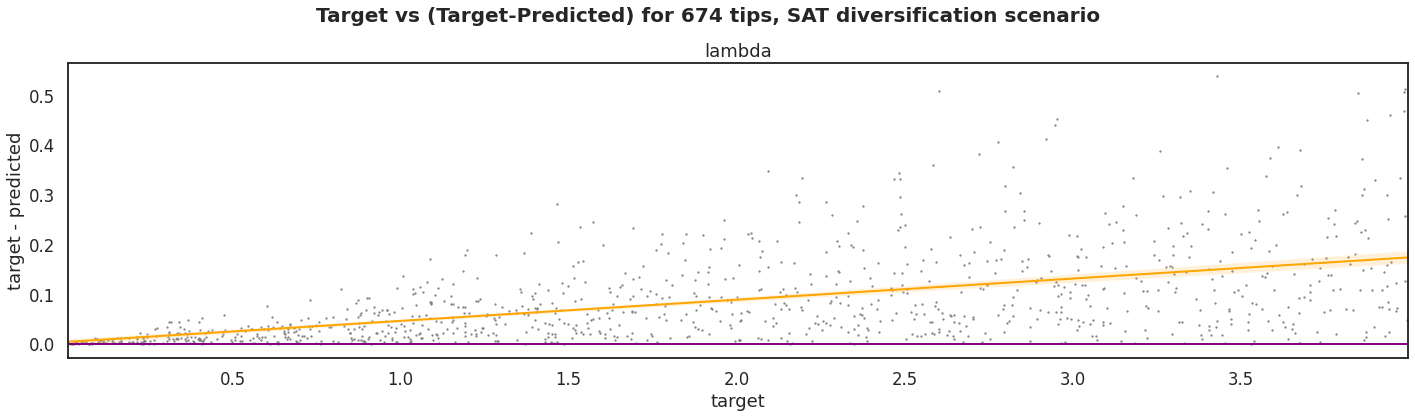

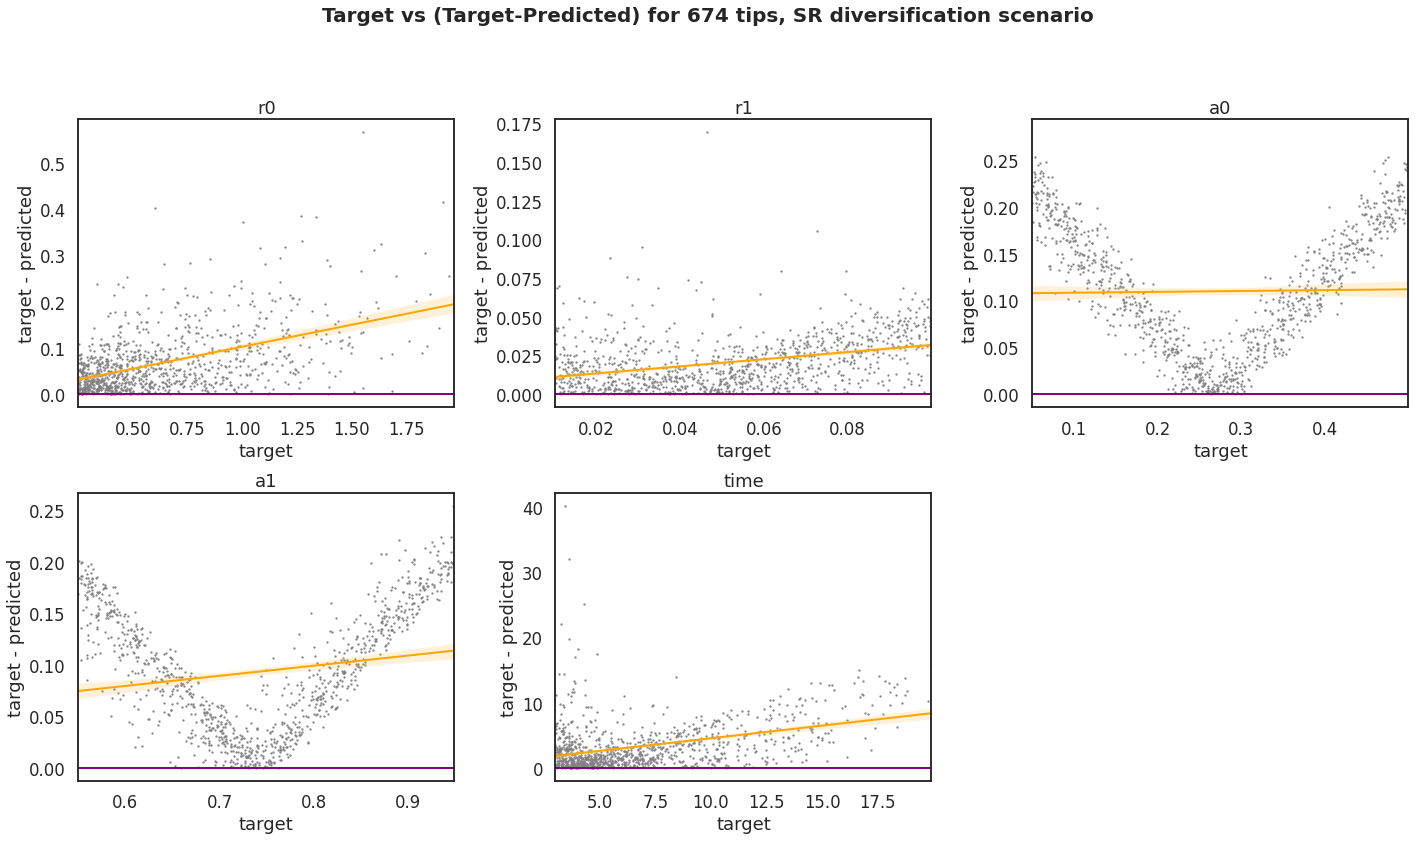

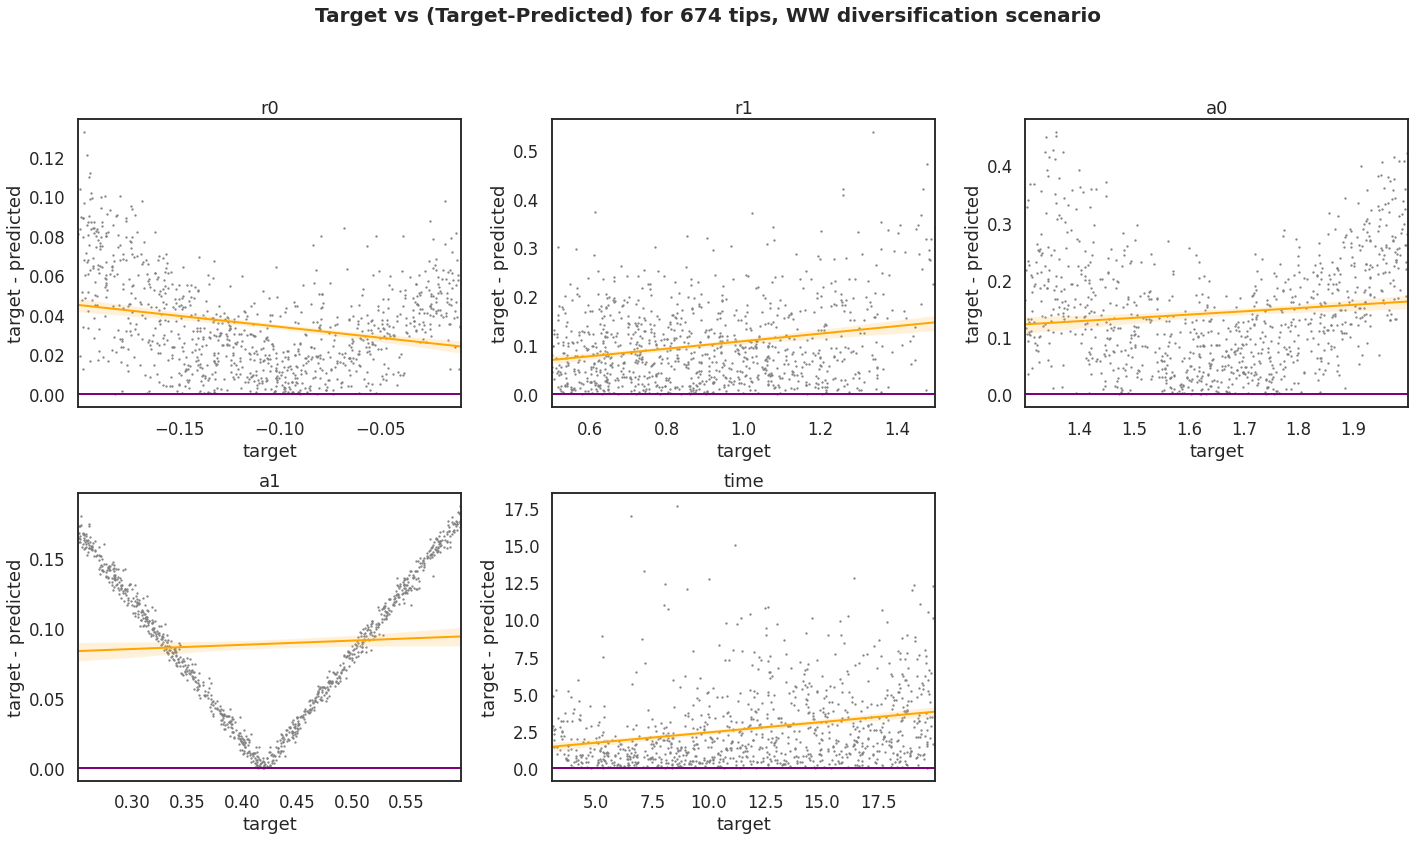

---------489---------


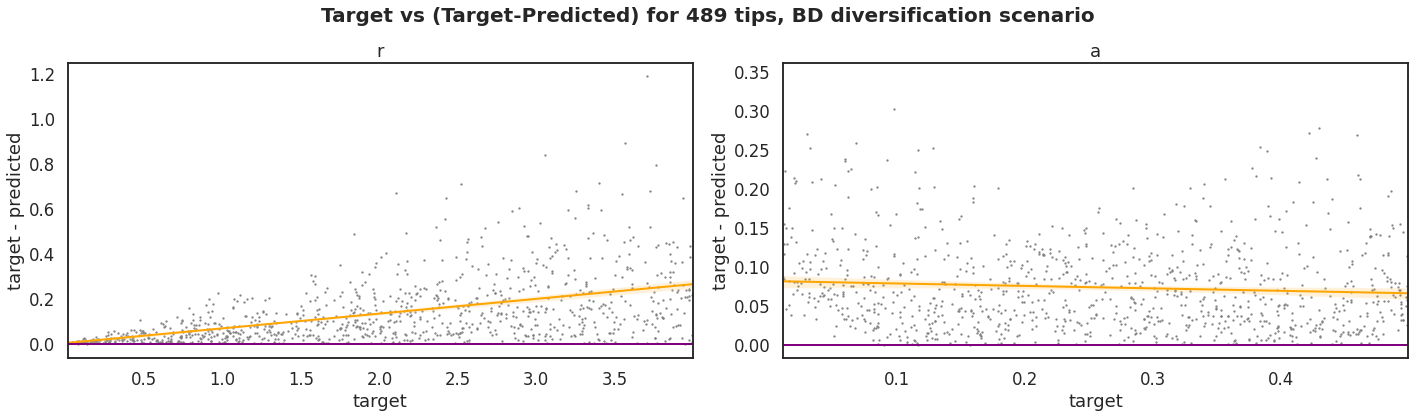

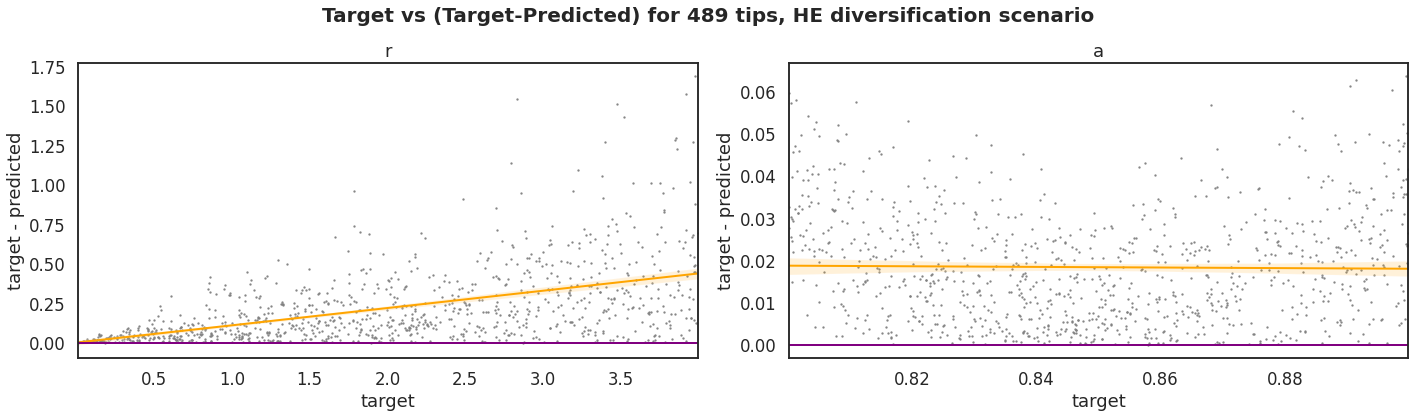

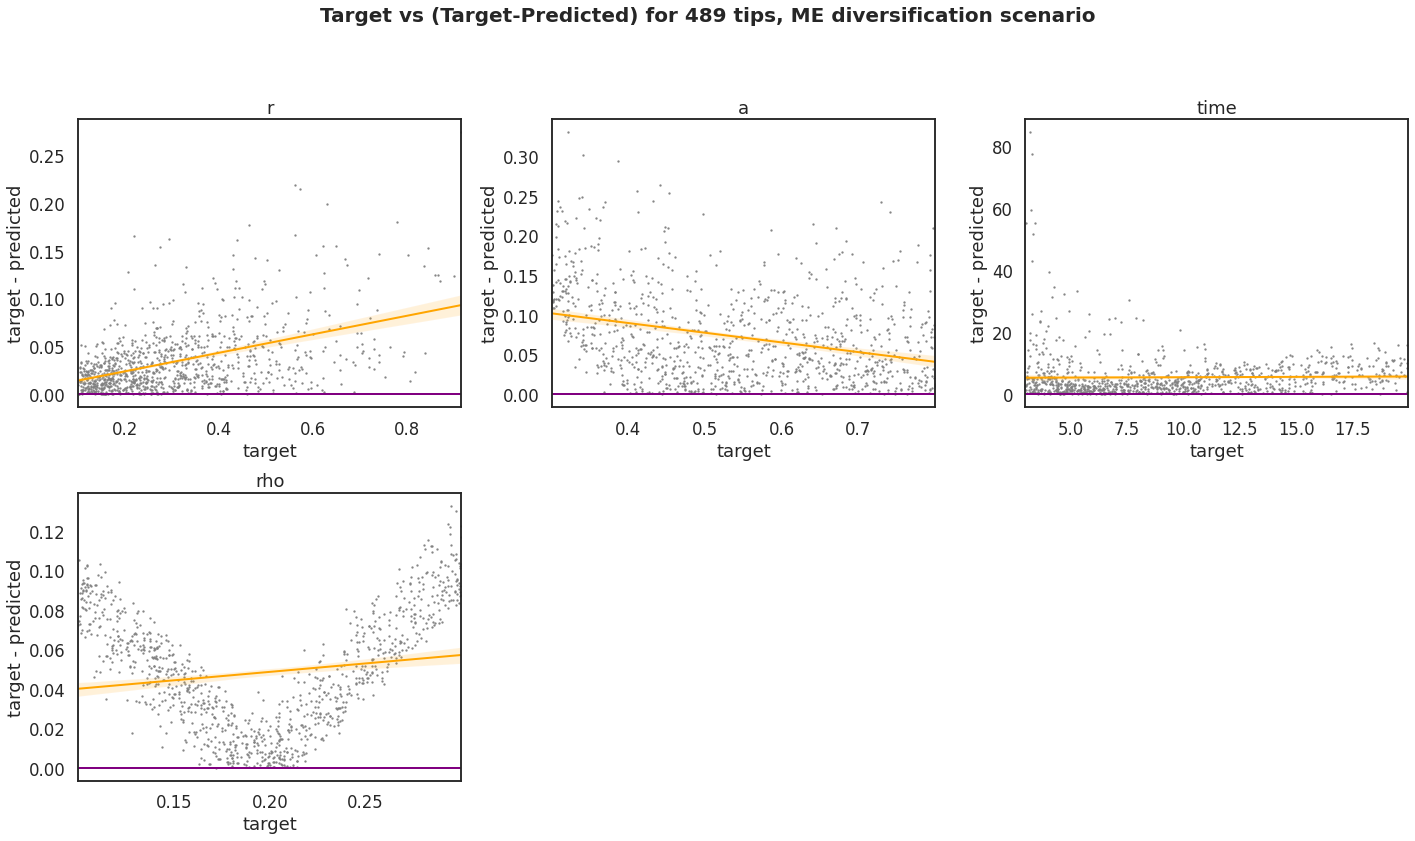

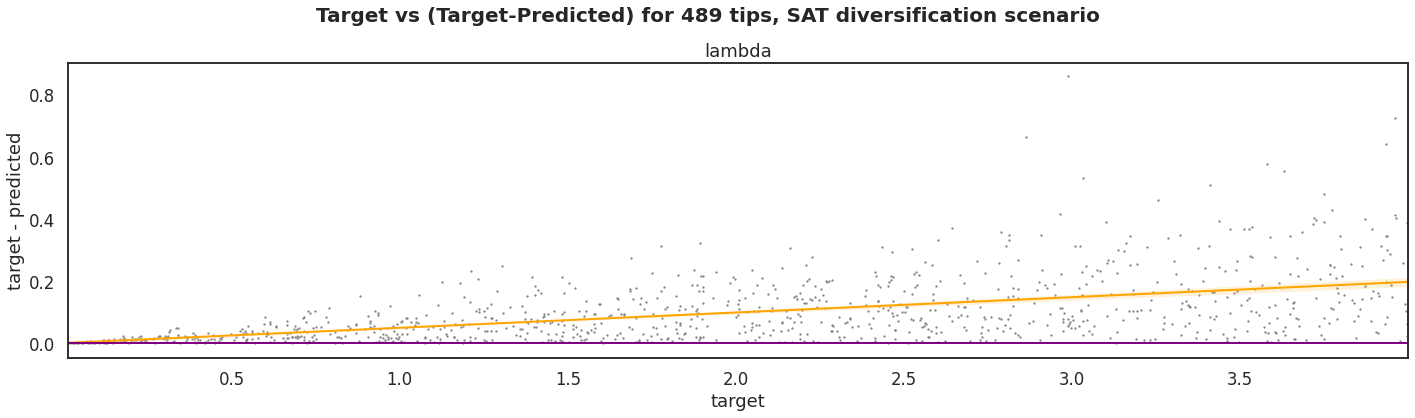

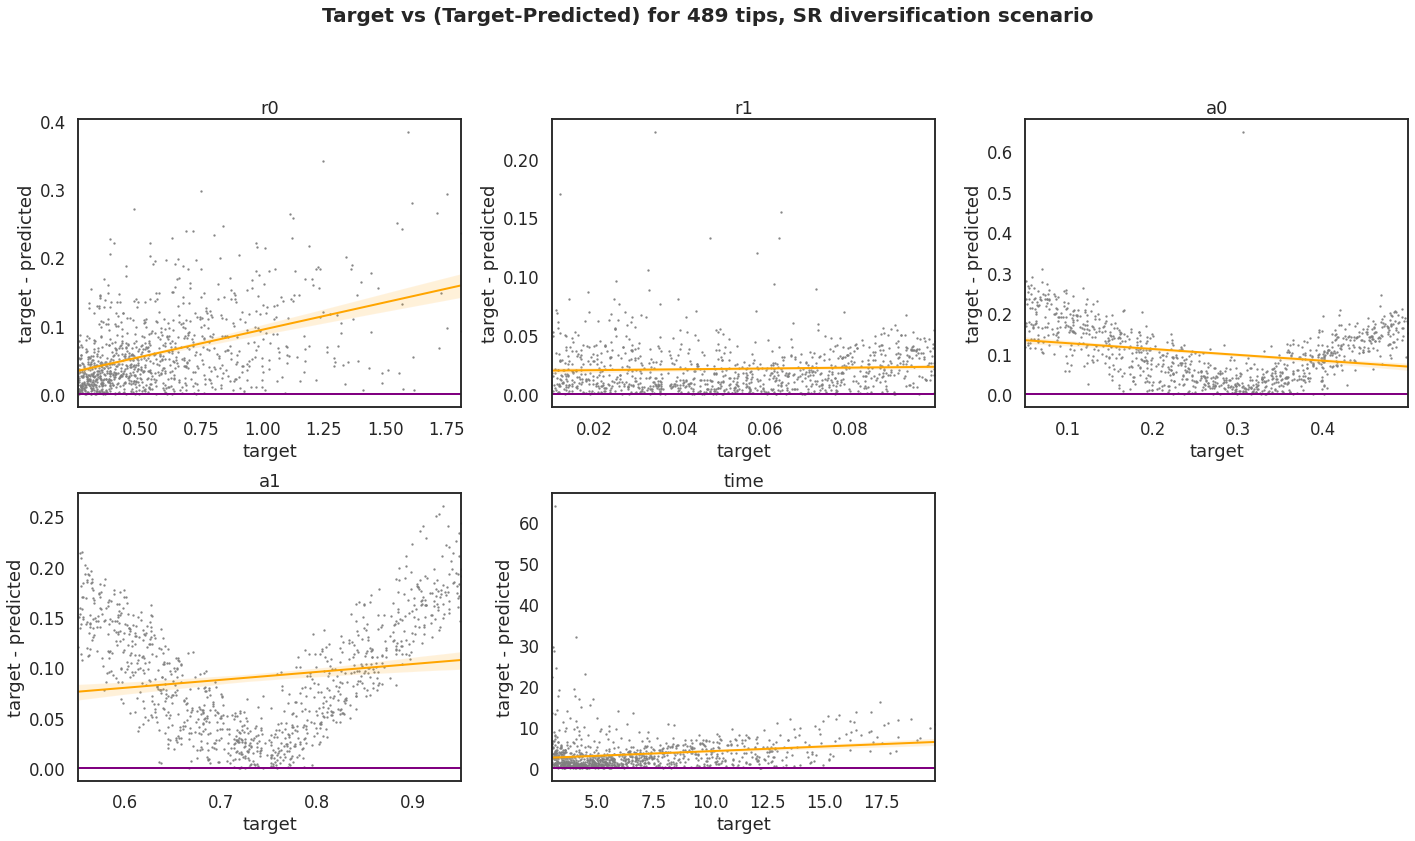

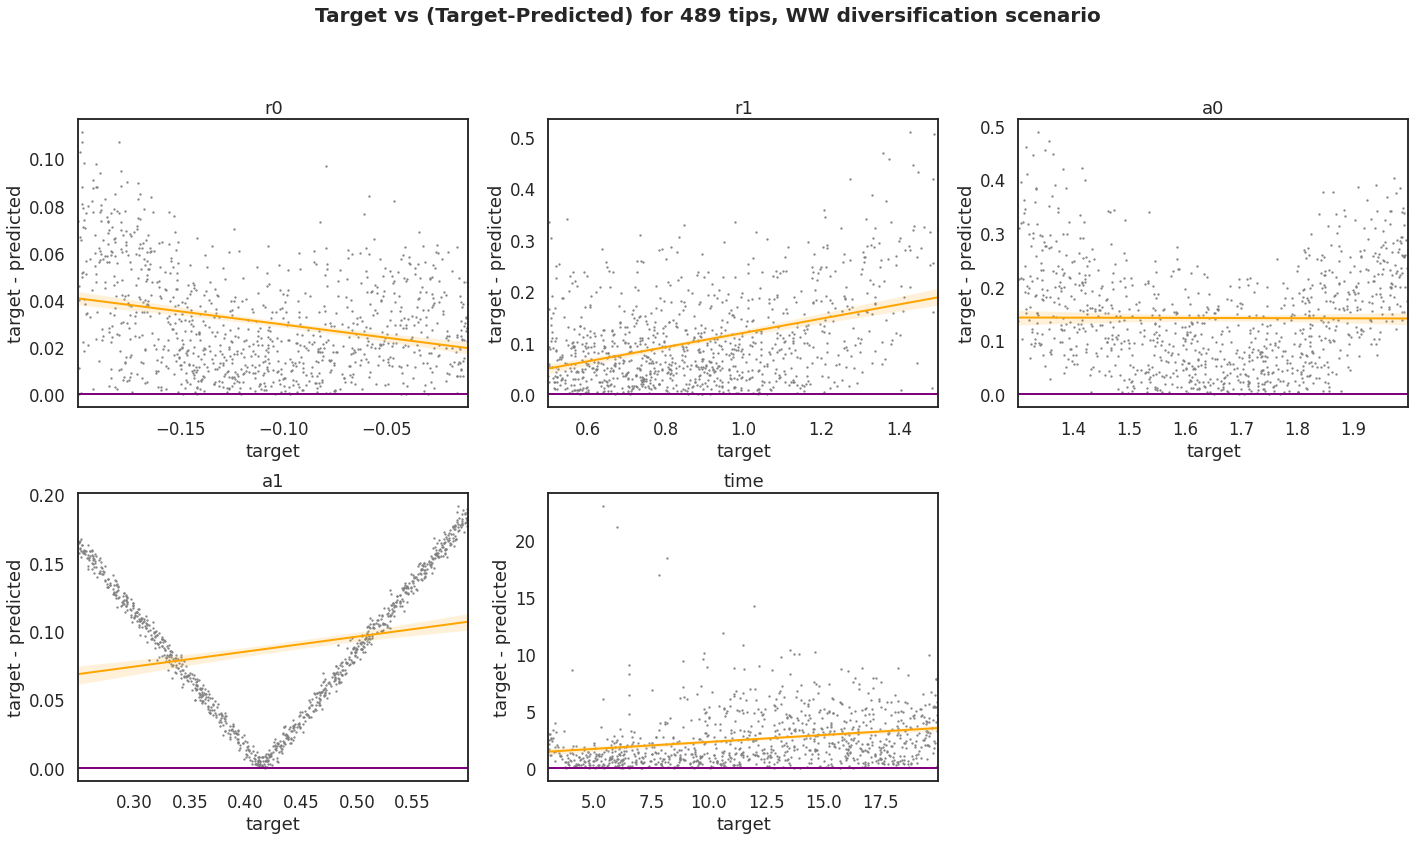

---------87---------


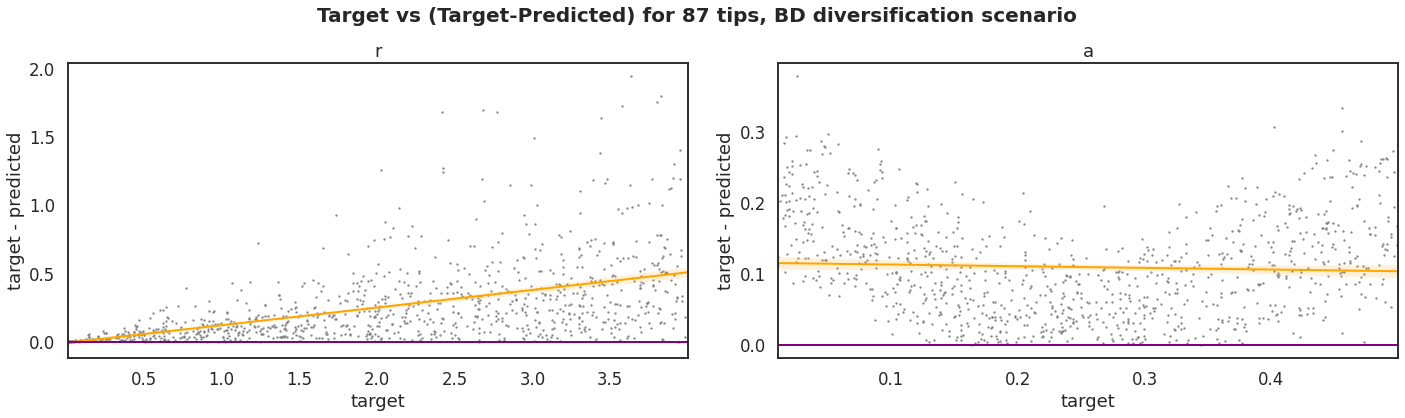

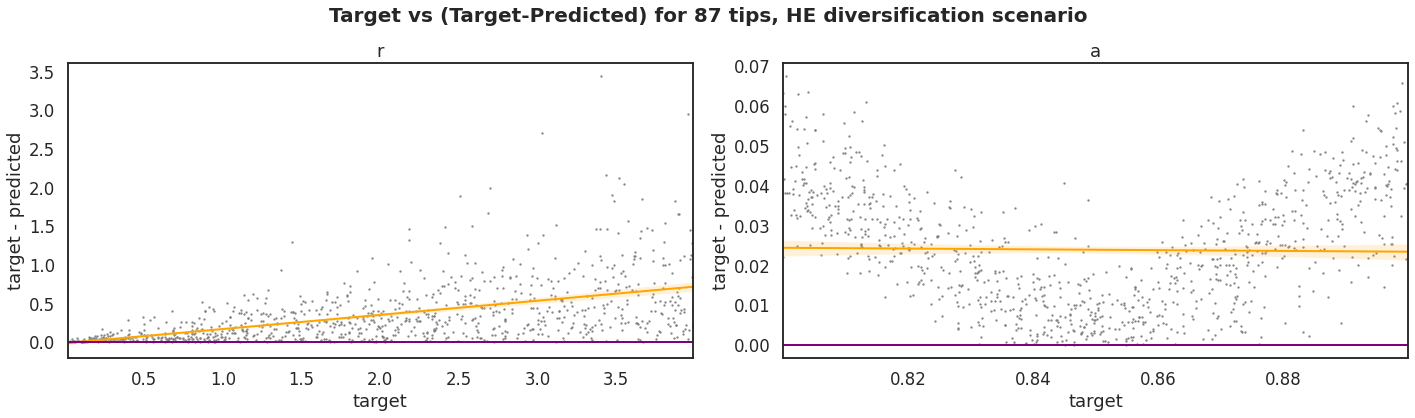

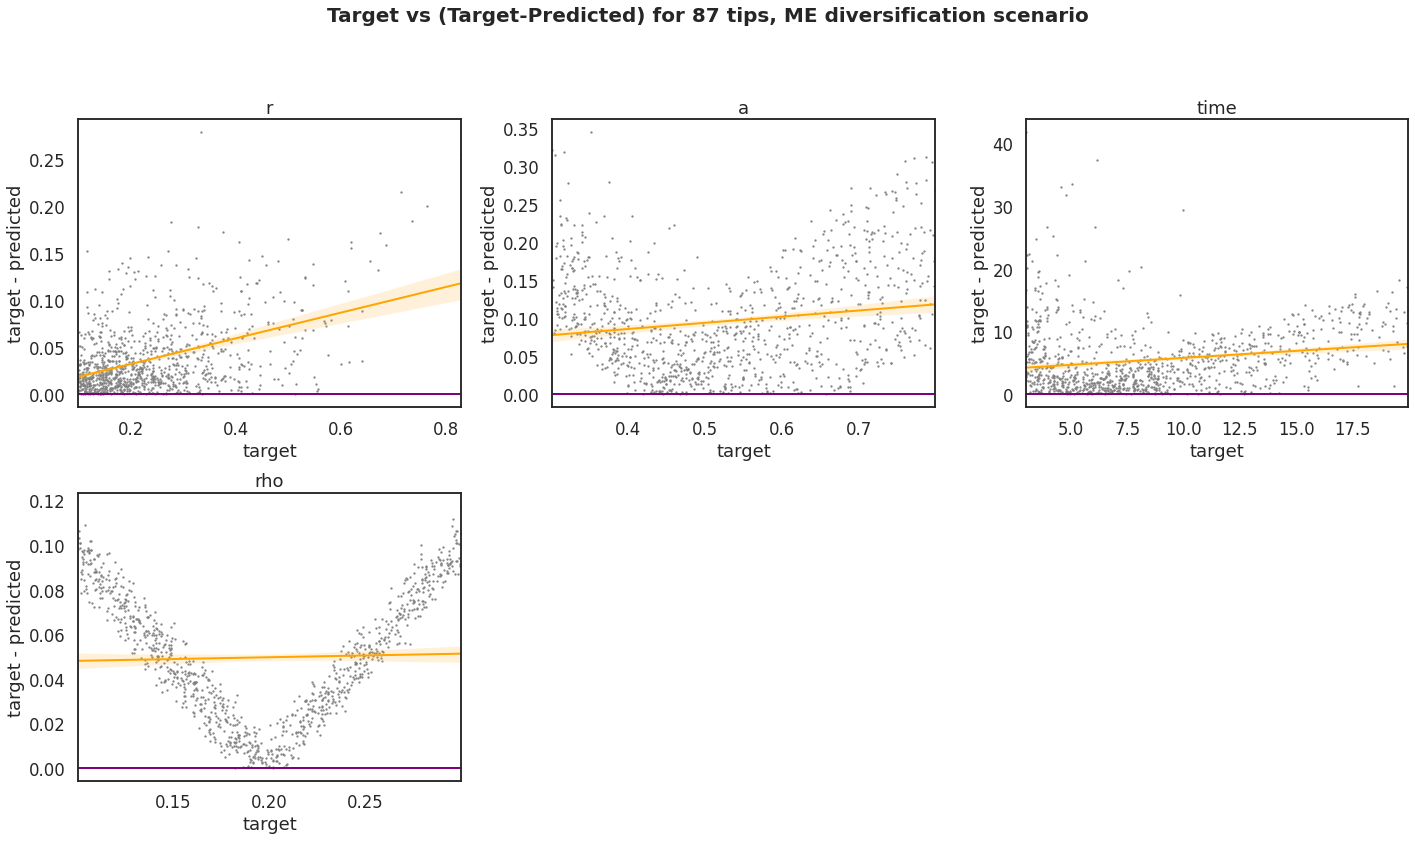

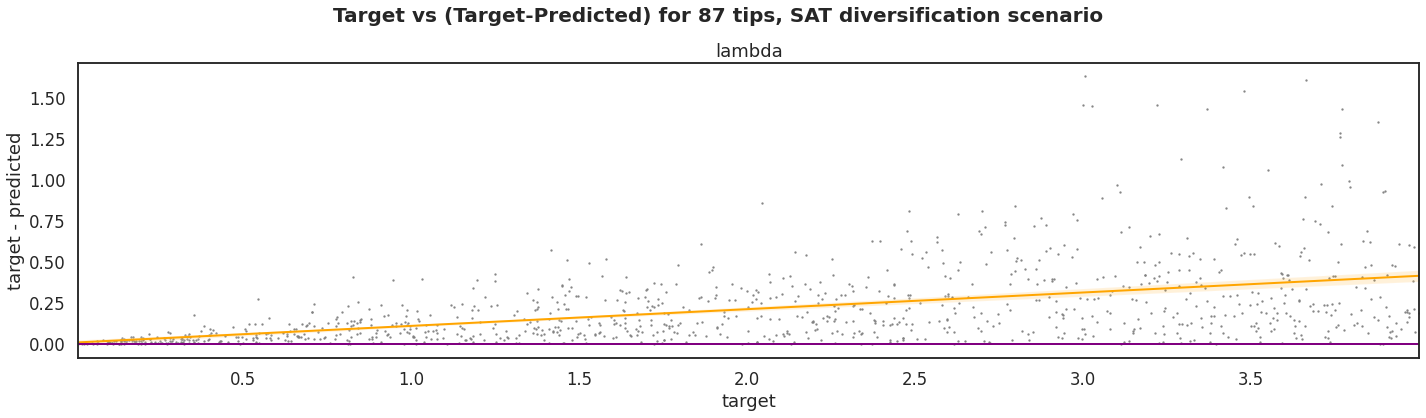

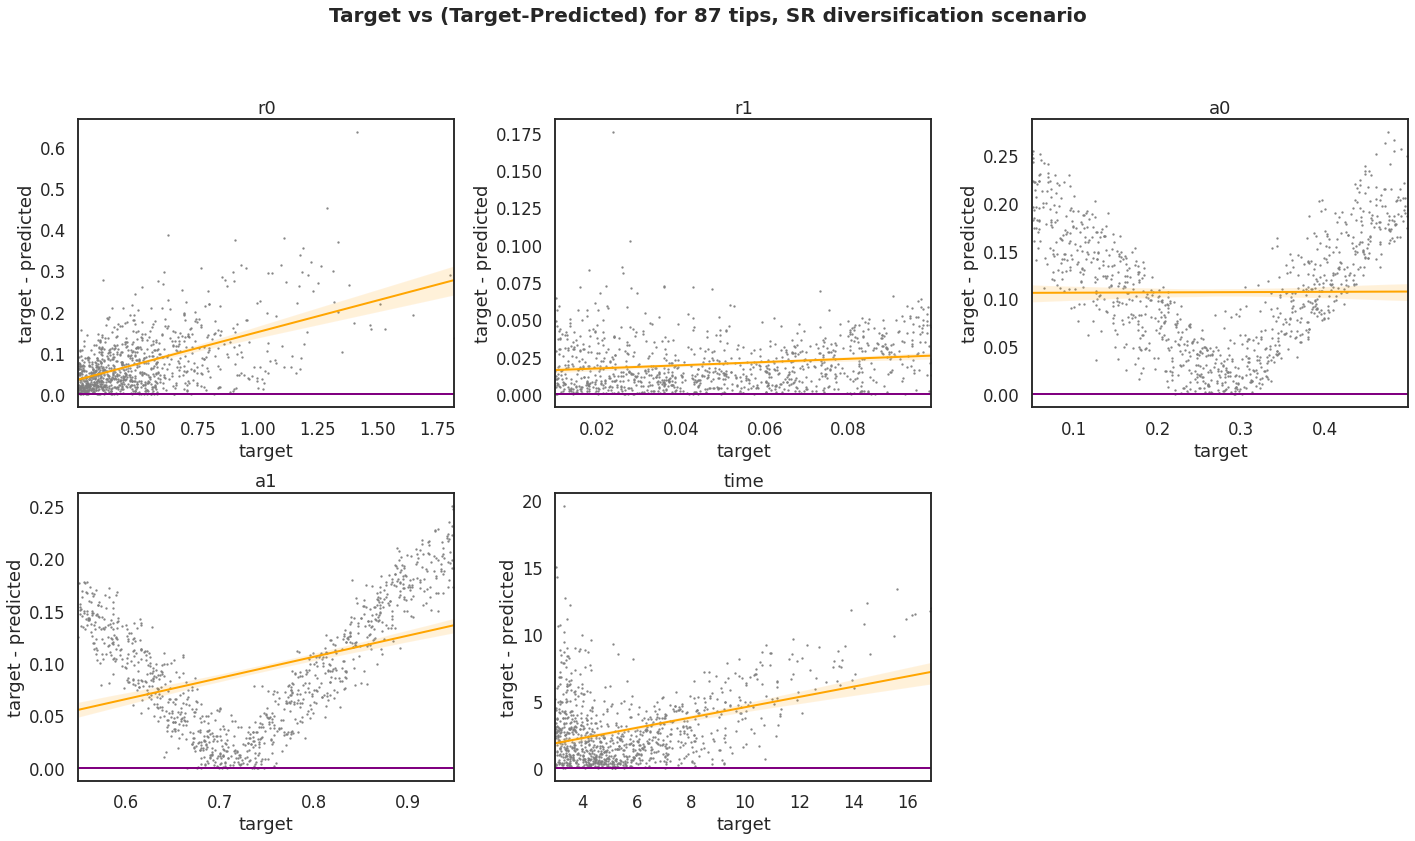

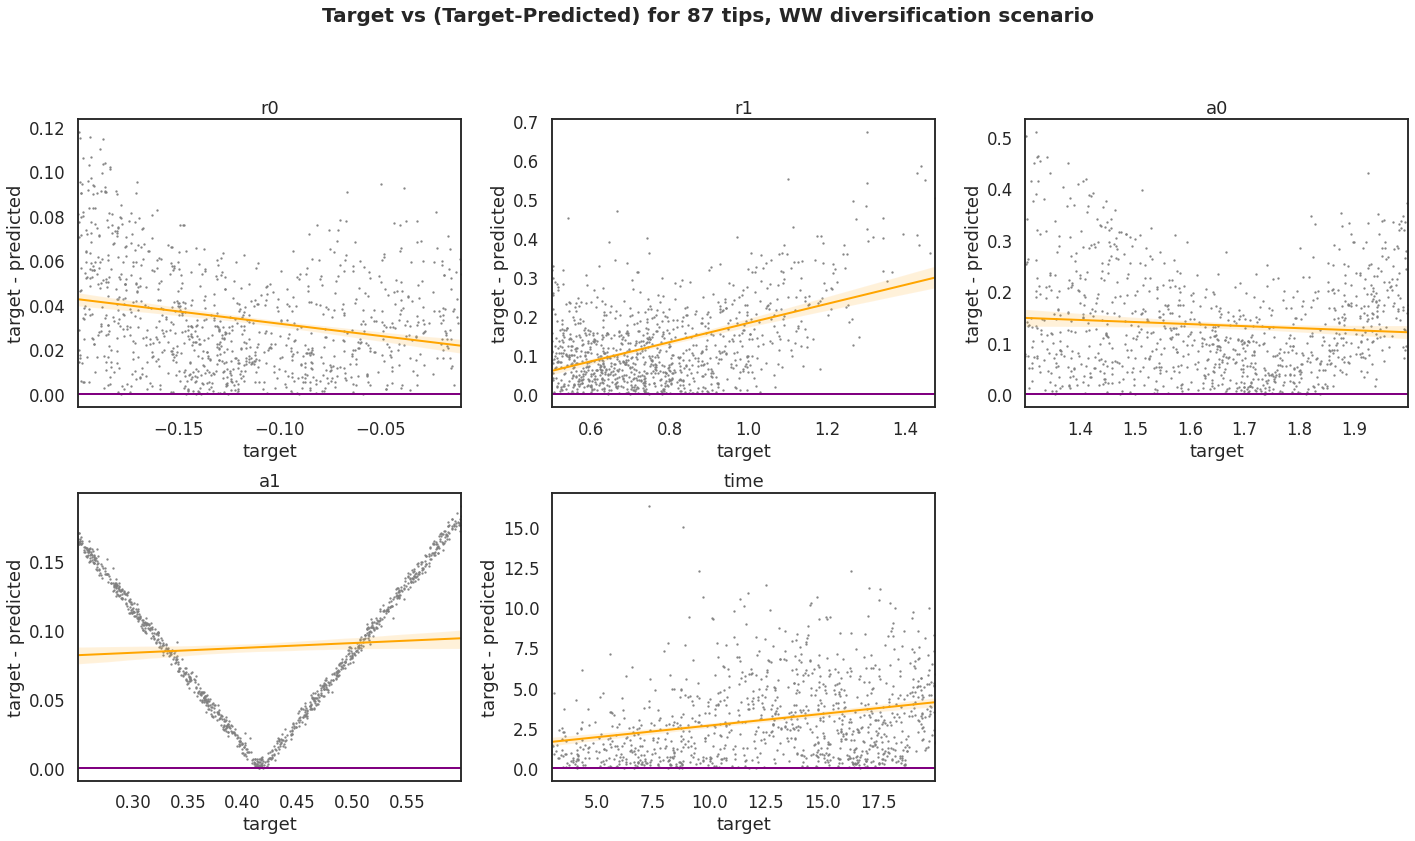

In [98]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios:
        predicted_minus_target_vs_target(results, tip, scenario)